<a href="https://colab.research.google.com/github/aditisingh2362/911-Emergency-Calls/blob/main/Emergency_911.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [7]:
import math
import pandas as pd
import numpy as np
from dateutil import relativedelta

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import geopandas as gpd
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

# Loading Data

In [8]:
dataset=pd.read_csv("911.csv")

In [9]:
dataset.head()

lat        lng  ...                        addr  e
0  40.297876 -75.581294  ...      REINDEER CT & DEAD END  1
1  40.258061 -75.264680  ...  BRIAR PATH & WHITEMARSH LN  1
2  40.121182 -75.351975  ...                    HAWS AVE  1
3  40.116153 -75.343513  ...          AIRY ST & SWEDE ST  1
4  40.251492 -75.603350  ...    CHERRYWOOD CT & DEAD END  1

[5 rows x 9 columns]



---



# Data Understanding and Cleaning

In [10]:
dataset.shape

(663522, 9)

**Observations**


*  Dataset comprises of 631339 observations and 9 fields.




In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663522 entries, 0 to 663521
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   lat        663522 non-null  float64
 1   lng        663522 non-null  float64
 2   desc       663522 non-null  object 
 3   zip        583323 non-null  float64
 4   title      663522 non-null  object 
 5   timeStamp  663522 non-null  object 
 6   twp        663229 non-null  object 
 7   addr       663522 non-null  object 
 8   e          663522 non-null  int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 45.6+ MB


**Observations**

*   Data has float, integer, and object type values.

*   Data type of timeStamp is object that need to convert to datetime.





In [12]:
dataset.columns

Index(['lat', 'lng', 'desc', 'zip', 'title', 'timeStamp', 'twp', 'addr', 'e'], dtype='object')

**Observations**

The data contains the following fields:
* lat : String variable, Latitude
* lng: String variable, Longitude
* desc: String variable, Description of the Emergency Call
* zip: String variable, Zipcode
* title: String variable, Title
* timeStamp: String variable, YYYY-MM-DD HH:MM:SS
* twp: String variable, Township
* addr: String variable, Address
* e: String variable, Dummy variable (always 1)



In [13]:
dataset.drop('e', axis=1, inplace=True)

In [14]:
type(dataset['timeStamp'].iloc[0])

str

In [15]:
dataset['timeStamp'] = pd.to_datetime(dataset['timeStamp'])

mindate = dataset["timeStamp"].min()
maxdate = dataset["timeStamp"].max()
dif = relativedelta.relativedelta(pd.to_datetime(maxdate), pd.to_datetime(mindate))
print("{} years and {} months".format(dif.years, dif.months))



4 years and 7 months


**Observations**

* So in a 4 years and 7 months of time span from Dec 2015 to April 2020, about 6.3 hundred people called emergency number 911 to get help in Montgomery County, PA.

In [16]:
dataset['Hour'] = dataset['timeStamp'].apply(lambda time: time.hour)

dataset['Day'] = dataset['timeStamp'].apply(lambda time: time.dayofweek)
dmap = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
dataset['Day'] = dataset['Day'].map(dmap)


dataset['Month'] = dataset['timeStamp'].apply(lambda time: time.month)
dmap = {1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}
dataset['Month'] = dataset['Month'].map(dmap)

dataset['Year'] = dataset['timeStamp'].apply(lambda time: time.year)

dataset['Date'] = dataset['timeStamp'].apply(lambda time:time.date())



---



### 'desc' field : Description of the Emergency Call

'desc' field contains three information, Address, Township and Station code seperated by semi-column. So lets seperate them out to get the station code, to which the call has been made and drop the 'desc' field.


In [17]:
dataset['station_code']=dataset['desc'].str.split('Station', expand=True)[1].str.split(';', expand=True)[0]
dataset['station_code'] = dataset['station_code'].str.replace(':', '')
dataset['station_code']= dataset['station_code'].str.strip()
dataset['station_code'].head(10)

dataset.drop(['desc'], axis=1, inplace=True)

In the titles column there are "Reasons/Departments" specified before the title code. These are EMS, Fire, and Traffic. So lets split into Type and Reason.

In [18]:
dataset['Type'] = dataset["title"].apply(lambda x: x.split(':')[0])
dataset['Reason'] = dataset["title"].apply(lambda x: x.split(':')[1])



---



# Exploratory Data Analysis (EDA)

In [19]:
dataset["Type"].value_counts()

EMS        332692
Traffic    230208
Fire       100622
Name: Type, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


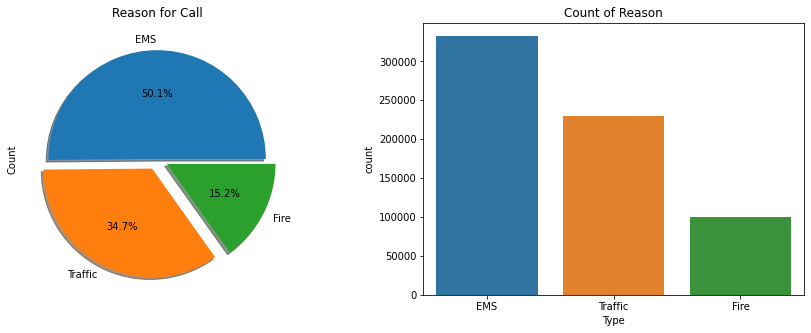

In [20]:
f,ax=plt.subplots(1,2,figsize=(15,5))
dataset['Type'].value_counts().plot.pie(explode=[0,0.1,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Reason for Call')
ax[0].set_ylabel('Count')
sns.countplot('Type',data=dataset,ax=ax[1],order=dataset['Type'].value_counts().index)
ax[1].set_title('Count of Reason')
plt.show()

**Observations**

* The number one reason for 911 calls are Emergency Medical Services (EMS).
* Almost half of the reasons are for EMS.

In [21]:
dataset["title"].value_counts()

Traffic: VEHICLE ACCIDENT -    148372
Traffic: DISABLED VEHICLE -     47909
Fire: FIRE ALARM                38336
EMS: FALL VICTIM                34676
EMS: RESPIRATORY EMERGENCY      34248
                                ...  
Fire: SUSPICIOUS                    1
EMS: POLICE INFORMATION             1
Fire: DIZZINESS                     1
Fire: HEMORRHAGING                  1
Fire: FOOT PATROL                   1
Name: title, Length: 148, dtype: int64

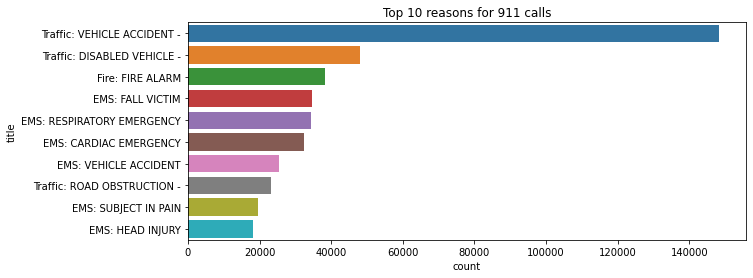

In [22]:
fig,ax=plt.subplots(figsize=(10,4))
sns.countplot(y='title',data=dataset,order=dataset['title'].value_counts().head(10).index)
plt.title('Top 10 reasons for 911 calls')
plt.show()

**Observations**

The bar chart shows top 10 reason for 911 calls.
* Vehicle accidents are the number one reason people call 911.
* Disabled vehicle and fire alarm are in second and third place.



---



#### Traffic 911 Emergency Calls

In [23]:
traffic=dataset[dataset['Type']=='Traffic']
traffic['Reason'].value_counts()

 VEHICLE ACCIDENT -             148372
 DISABLED VEHICLE -              47909
 ROAD OBSTRUCTION -              23235
 HAZARDOUS ROAD CONDITIONS -      6833
 VEHICLE FIRE -                   3366
 VEHICLE LEAKING FUEL -            292
 DEBRIS/FLUIDS ON HIGHWAY -        201
Name: Reason, dtype: int64

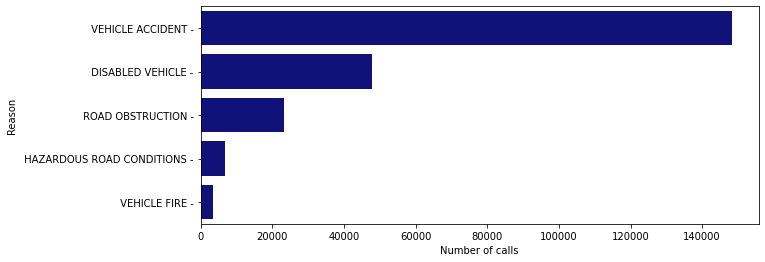

In [24]:
fig,ax=plt.subplots(figsize=(10,4))
sns.countplot(y='Reason',data=traffic,order=traffic['Reason'].value_counts().head().index, color='darkblue')
ax.set_xlabel('Number of calls')
plt.show()

**Observations**

* The most common emergency titles are vehicle accident, disable vehicle and road obstruction.


---



#### Fire 911 Emergency Calls

In [25]:
fire=dataset[dataset['Type']=='Fire']
fire['Reason'].value_counts()

 FIRE ALARM                      38336
 VEHICLE ACCIDENT                10864
 FIRE INVESTIGATION               9444
 GAS-ODOR/LEAK                    6740
 ELECTRICAL FIRE OUTSIDE          5111
 BUILDING FIRE                    4754
 FIRE SPECIAL SERVICE             4050
 CARBON MONOXIDE DETECTOR         3990
 VEHICLE FIRE                     3232
 WOODS/FIELD FIRE                 2486
 UNKNOWN TYPE FIRE                1964
 FIRE POLICE NEEDED               1587
 CARDIAC ARREST                   1364
 APPLIANCE FIRE                   1217
 TRASH/DUMPSTER FIRE              1190
 ELEVATOR EMERGENCY                920
 RESCUE - ELEVATOR                 736
 S/B AT HELICOPTER LANDING         658
 RESCUE - GENERAL                  376
 VEHICLE LEAKING FUEL              337
 RESCUE - WATER                    295
 DEBRIS/FLUIDS ON HIGHWAY          256
 BURN VICTIM                       227
 PUMP DETAIL                       171
 TRANSFERRED CALL                  102
 HAZARDOUS MATERIALS INCI

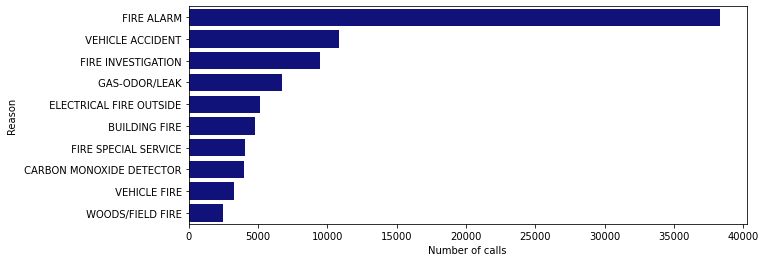

In [26]:
fig,ax=plt.subplots(figsize=(10,4))
sns.countplot(y='Reason',data=fire,order=fire['Reason'].value_counts().head(10).index, color='darkblue')
ax.set_xlabel('Number of calls')
plt.show()

**Observation**

* The most common emergency titles are fire alarm, vehicle accident and fire investigation.



---



#### EMS 911 Emergency Calls

In [27]:
EMS=dataset[dataset['Type']=='EMS']
EMS['Reason'].value_counts()

 FALL VICTIM              34676
 RESPIRATORY EMERGENCY    34248
 CARDIAC EMERGENCY        32332
 VEHICLE ACCIDENT         25513
 SUBJECT IN PAIN          19646
                          ...  
 SUICIDE THREAT               2
 POLICE INFORMATION           1
 HIT + RUN                    1
 VEHICLE LEAKING FUEL         1
 DISABLED VEHICLE             1
Name: Reason, Length: 81, dtype: int64

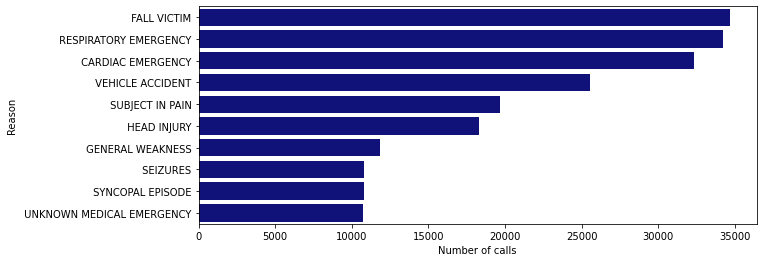

In [28]:
fig,ax=plt.subplots(figsize=(10,4))
sns.countplot(y='Reason',data=EMS,order=EMS['Reason'].value_counts().head(10).index, color='darkblue')
ax.set_xlabel('Number of calls')
plt.show()

**Observations**

* The most common emergency titles are fall victim, respiratory emergency and cardiac emergency.

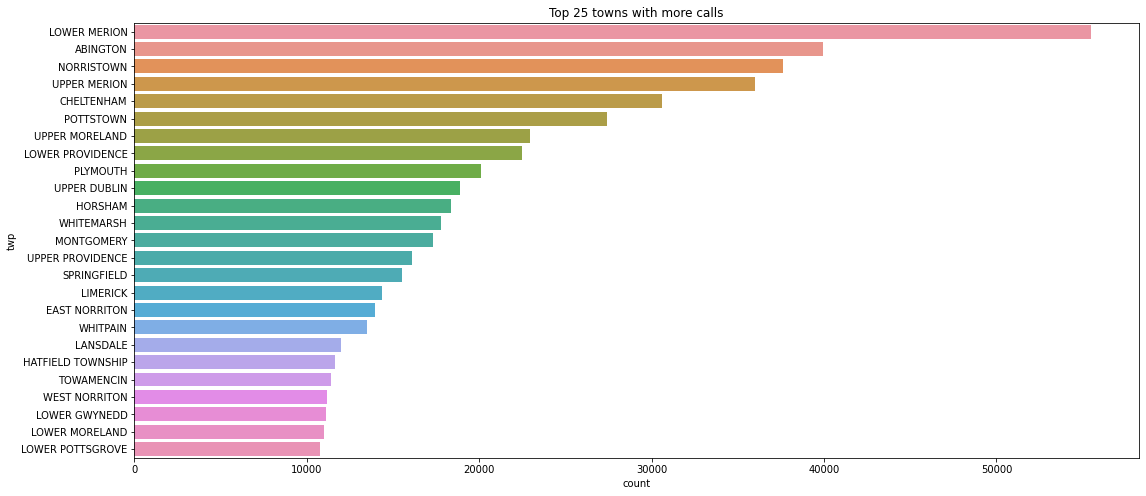

In [29]:
fig,ax=plt.subplots(figsize=(18,8))
sns.countplot(y='twp',data=dataset,order=dataset['twp'].value_counts().head(25).index)
plt.title('Top 25 towns with more calls')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


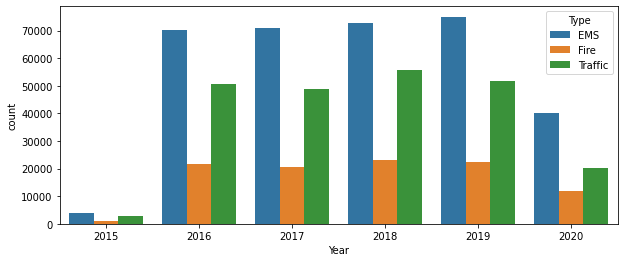

In [30]:
fig,ax=plt.subplots(figsize=(10,4))
sns.countplot('Year',data=dataset,hue='Type')
plt.show()

**Observations**

* Emergency calls are almost same throughout the year, except for year 2015 and 2020.
* Our dataset contains data for only one month of year 2015 and only four months of year 2020. 
* So data is not available for complete year of 2015 and 2020.

 

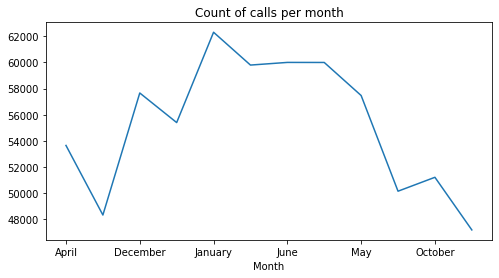

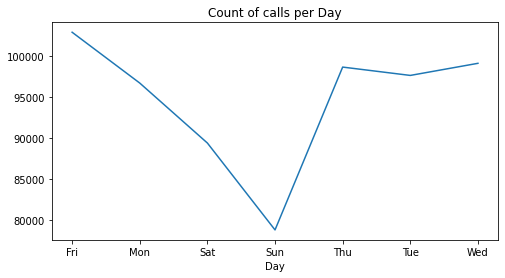

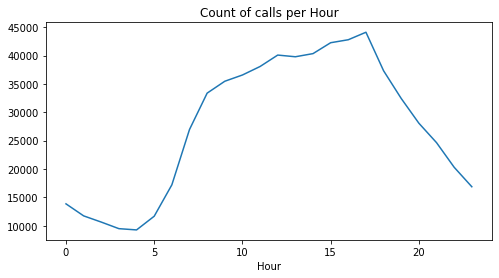

In [31]:
#month
byMonth = dataset.groupby('Month').count().sort_values(by='Month',ascending=True)
byMonth['twp'].plot(figsize=(8, 4))
plt.title('Count of calls per month')
plt.show()
#day
byDay = dataset.groupby('Day').count().sort_values(by='Day',ascending=True)
byDay['twp'].plot(figsize=(8, 4))
plt.title('Count of calls per Day')
plt.show()
#hour
byHour = dataset.groupby('Hour').count().sort_values(by='Hour',ascending=True)
byHour['twp'].plot(figsize=(8, 4))
plt.title('Count of calls per Hour')
plt.show()

**Observation**
* Maximum number of emergency calls happened at round 5PM.
* Maximum number of emergency calls happened on friday and minimum on sunday.
* Maximum emergency service required in the months of Jan,Feb, March and Dec.

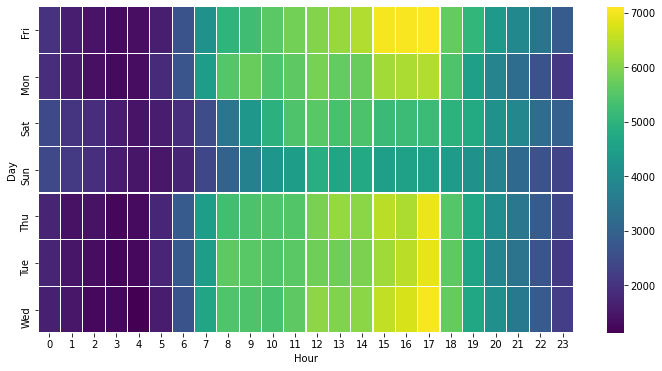

In [32]:
dayHour = dataset.groupby(['Day','Hour']).count()['Type'].unstack()
fig,ax=plt.subplots(figsize=(12,6))
sns.heatmap(dayHour,cmap='viridis',linewidths=.1)
plt.show()

**Observation**
* Less emergency service required at night or early morning,while more at evening time and that is even more on Friday.


In [33]:
latest=dataset[dataset['Year']==2020]

lat_traffic=traffic[traffic['Year']==2020]
lat_fire=fire[fire['Year']==2020]
lat_EMS=EMS[EMS['Year']==2020]

lat_fire.shape

(11999, 15)

In [35]:
m = folium.Map(location=[40.158162,-75.300105], tiles='cartodbpositron', zoom_start=5)

mc = MarkerCluster()
for idx, row in lat_traffic.iterrows():
    if not math.isnan(row['lng']) and not math.isnan(row['lat']):
        mc.add_child(Marker([row['lat'], row['lng']]))
m.add_child(mc)

m

#### Dealing With Missing Values

In [37]:
total=dataset.isnull().sum().sort_values(ascending=False)
percent=(dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

Total   Percent
station_code  230208  0.346949
zip            80199  0.120869
twp              293  0.000442
Reason             0  0.000000
Type               0  0.000000
Date               0  0.000000
Year               0  0.000000
Month              0  0.000000
Day                0  0.000000
Hour               0  0.000000

In [38]:
dataset.dropna(subset=['twp'],inplace=True)

In [39]:
dataset.dropna(subset=['zip'],inplace=True)

In [40]:
total=dataset.isnull().sum().sort_values(ascending=False)
percent=(dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

Total   Percent
station_code  189597  0.325098
Reason             0  0.000000
Type               0  0.000000
Date               0  0.000000
Year               0  0.000000
Month              0  0.000000
Day                0  0.000000
Hour               0  0.000000
addr               0  0.000000
twp                0  0.000000

# Treating Outliers

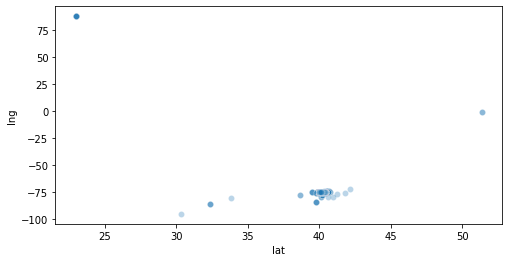

In [41]:
fig,ax = plt.subplots(figsize=(8,4))
sns.scatterplot(x='lat',y='lng',data=dataset, alpha=0.3)
plt.show()

Apparently there are some outliers. Let's use boxplot to do this analysis.

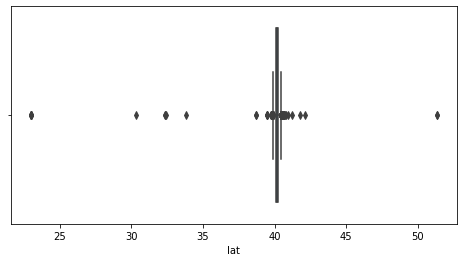

In [42]:
#Analysing Latitude
fig,ax = plt.subplots(figsize=(8,4))
sns.boxplot(x=dataset['lat'])
plt.show()

In [43]:
Q1=dataset['lat'].quantile(.25)
Q3=dataset['lat'].quantile(.75)
IQR=Q3-Q1
Lower_Whisker=Q1-1.5*IQR
Upper_Whisker = Q3+1.5*IQR

dataset_treated=dataset[(dataset['lat']<Upper_Whisker)&(dataset['lat']>Lower_Whisker)]

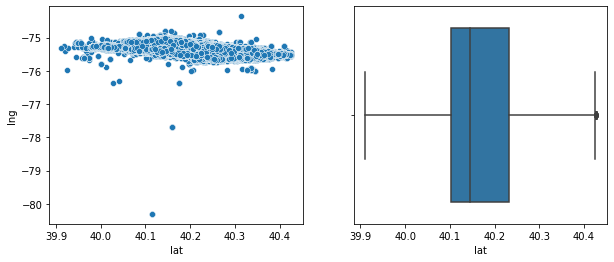

In [44]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
sns.scatterplot(x=dataset_treated['lat'],y=dataset_treated['lng'],data=dataset,ax=ax[0])
sns.boxplot(x=dataset_treated['lat'],ax=ax[1])
plt.show()

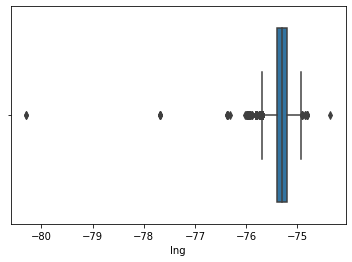

In [45]:
sns.boxplot(x=dataset_treated['lng'])

In [46]:
Q1=dataset_treated['lng'].quantile(.25)
Q3=dataset_treated['lng'].quantile(.75)
IQR=Q3-Q1
Lower_Whisker=Q1-1.5*IQR
Upper_Whisker = Q3+1.5*IQR
dataset_treated=dataset_treated[(dataset_treated['lng']<Upper_Whisker)&(dataset_treated['lng']>Lower_Whisker)]

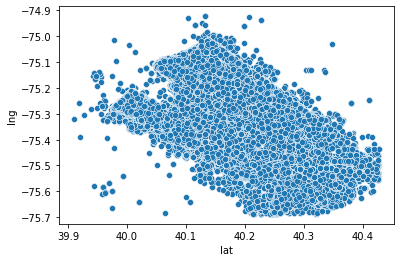

In [47]:
sns.scatterplot(x=dataset_treated['lat'],y=dataset_treated['lng'],data=dataset)

In [48]:
dataset_treated.shape

(581355, 15)


# **Association Rule Mining**
---






## **Preprocess Data for the** **Algorithm**

In [51]:
df=dataset_treated.drop(['station_code'], axis=1)

In [52]:
title_low=df["title"].value_counts()
sum=0
others=[]
for i in title_low.index:
    if(title_low[i]<=1000):
        sum=sum+title_low[i]
        others.append(i)
print(len(others))

def convert(x):
    if x in others:
        return "Others"
    else:
        return x
df.title = df.title.map(convert)

91


In [53]:
titles=df['title'].unique().tolist()
one_hot = pd.get_dummies(df['title'])
df.drop('title', inplace=True, axis=1)
df = df.join(one_hot)
df.head()

lat        lng  ...  Traffic: VEHICLE ACCIDENT - Traffic: VEHICLE FIRE -
0  40.297876 -75.581294  ...                            0                       0
1  40.258061 -75.264680  ...                            0                       0
2  40.121182 -75.351975  ...                            0                       0
3  40.116153 -75.343513  ...                            0                       0
5  40.253473 -75.283245  ...                            0                       0

[5 rows x 66 columns]

In [54]:
townships=df['twp'].unique().tolist()
one_hot = pd.get_dummies(df['twp'])
df.drop('twp', inplace=True, axis=1)
df = df.join(one_hot)
df.head()

lat        lng      zip  ... WHITEMARSH WHITPAIN  WORCESTER
0  40.297876 -75.581294  19525.0  ...          0        0          0
1  40.258061 -75.264680  19446.0  ...          0        0          0
2  40.121182 -75.351975  19401.0  ...          0        0          0
3  40.116153 -75.343513  19401.0  ...          0        0          0
5  40.253473 -75.283245  19446.0  ...          0        0          0

[5 rows x 133 columns]

In [55]:
months=df['Month'].unique().tolist()
one_hot = pd.get_dummies(df['Month'])
df.drop('Month', inplace=True, axis=1)
df = df.join(one_hot)
df.head()

lat        lng      zip  ... November October  September
0  40.297876 -75.581294  19525.0  ...        0       0          0
1  40.258061 -75.264680  19446.0  ...        0       0          0
2  40.121182 -75.351975  19401.0  ...        0       0          0
3  40.116153 -75.343513  19401.0  ...        0       0          0
5  40.253473 -75.283245  19446.0  ...        0       0          0

[5 rows x 144 columns]

In [56]:
def convertHr(x):
    if x>=6 and x<12:
        return "Morning"
    elif x>=12 and x<16:
        return "Afternoon"
    elif x>=16 and x<21:
        return "Evening"
    else:
        return "Night"
df.Hour = df.Hour.map(convertHr)

In [58]:
times=df['Hour'].unique().tolist()
one_hot = pd.get_dummies(df['Hour'])
df.drop('Hour', inplace=True, axis=1)
df = df.join(one_hot)
df.head()

lat        lng      zip  ... Evening Morning Night
0  40.297876 -75.581294  19525.0  ...       1       0     0
1  40.258061 -75.264680  19446.0  ...       1       0     0
2  40.121182 -75.351975  19401.0  ...       0       0     0
3  40.116153 -75.343513  19401.0  ...       1       0     0
5  40.253473 -75.283245  19446.0  ...       0       0     0

[5 rows x 147 columns]

In [59]:
days=df['Day'].unique().tolist()
one_hot = pd.get_dummies(df['Day'])
df.drop('Day', inplace=True, axis=1)
df = df.join(one_hot)
df.head()

lat        lng      zip           timeStamp  ... Sun  Thu Tue Wed
0  40.297876 -75.581294  19525.0 2015-12-10 17:10:52  ...   0    1   0   0
1  40.258061 -75.264680  19446.0 2015-12-10 17:29:21  ...   0    1   0   0
2  40.121182 -75.351975  19401.0 2015-12-10 14:39:21  ...   0    1   0   0
3  40.116153 -75.343513  19401.0 2015-12-10 16:47:36  ...   0    1   0   0
5  40.253473 -75.283245  19446.0 2015-12-10 15:39:04  ...   0    1   0   0

[5 rows x 153 columns]

In [60]:
df=df.drop(['timeStamp', 'Type', 'zip','Reason'], axis=1)

In [61]:
df=df.drop(['lat','lng'], axis=1)

In [62]:
df_new=df.drop(['addr','Year','Date'], axis=1)

In [63]:
df_new.head()

EMS: ABDOMINAL PAINS  EMS: ALLERGIC REACTION  ...  Tue  Wed
0                     0                       0  ...    0    0
1                     0                       0  ...    0    0
2                     0                       0  ...    0    0
3                     0                       0  ...    0    0
5                     0                       0  ...    0    0

[5 rows x 144 columns]

## **Apply** **Algorithm**

In [64]:
from mlxtend.frequent_patterns import apriori, association_rules

In [65]:
ap_0_5 = {}
ap_1 = {}
ap_5 = {}
ap_1_0 = {}

confidence = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

def gen_rules(df,confidence,support):
    ap = {}
    for i in confidence:
        ap_i =apriori(df_new,support,True, low_memory=True)
        rule= association_rules(ap_i,min_threshold=i)
        ap[i] = len(rule.antecedents)
    return pd.Series(ap).to_frame("Support: %s"%support)

confs = []
for i in [0.005,0.01,0.05,0.1]:
    ap_i = gen_rules(df_new,confidence=confidence,support=i)
    confs.append(ap_i)

all_conf = pd.concat(confs,axis=1)

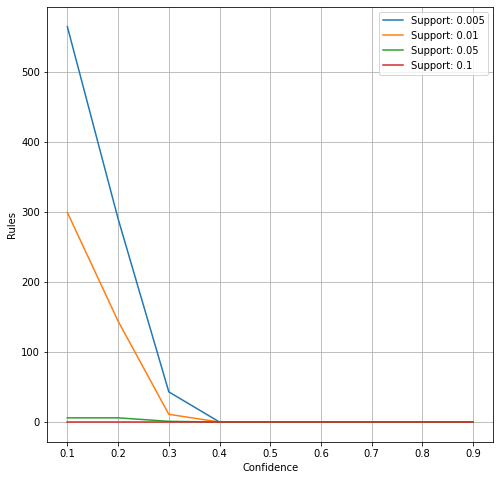

In [66]:
all_conf.plot(figsize=(8,8),grid=True)
plt.ylabel('Rules')
plt.xlabel('Confidence')
plt.show()

In [67]:
df_new.drop(['Traffic: VEHICLE ACCIDENT -'],axis=1,inplace=True)

In [68]:
import time

start_time=time.time()
frq_items = apriori(df_new, min_support = 0.005, use_colnames = True, low_memory=True) 
rules = association_rules(frq_items, metric ="lift", min_threshold = 0.03) 
end_time=time.time()
print("time elapsed", (end_time-start_time)/60)

rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 
print(rules.head()) 

time elapsed 0.06353161334991456
                      antecedents consequents  ...  leverage  conviction
65                (EMS: OVERDOSE)     (Night)  ...  0.002606    1.320548
55        (EMS: GENERAL WEAKNESS)   (Morning)  ...  0.001635    1.134229
108       (EMS: SYNCOPAL EPISODE)   (Morning)  ...  0.000614    1.051882
112       (EMS: VEHICLE ACCIDENT)   (Evening)  ...  0.001054    1.057240
0    (EMS: ALTERED MENTAL STATUS)   (Morning)  ...  0.000508    1.045195

[5 rows x 9 columns]


In [69]:
final_rules=rules[rules['confidence'] > 0.1]

In [70]:
final_rules.head(10)

antecedents consequents  ...  leverage  conviction
65                 (EMS: OVERDOSE)     (Night)  ...  0.002606    1.320548
55         (EMS: GENERAL WEAKNESS)   (Morning)  ...  0.001635    1.134229
108        (EMS: SYNCOPAL EPISODE)   (Morning)  ...  0.000614    1.051882
112        (EMS: VEHICLE ACCIDENT)   (Evening)  ...  0.001054    1.057240
0     (EMS: ALTERED MENTAL STATUS)   (Morning)  ...  0.000508    1.045195
173  (Traffic: DISABLED VEHICLE -)   (Evening)  ...  0.002207    1.050649
196  (Traffic: ROAD OBSTRUCTION -)   (Morning)  ...  0.000875    1.040042
499                   (WHITEMARSH)   (Morning)  ...  0.000574    1.031253
800                          (Mon)   (Morning)  ...  0.003173    1.031182
828                   (March, Fri)   (Evening)  ...  0.000421    1.036120

[10 rows x 9 columns]

### **Visualisation**

In [71]:
def draw_graph(rules, rules_to_show):
  import networkx as nx
  G1 = nx.DiGraph()

  color_map = []
  N = 50
  colors = np.random.rand(N)
  strs=['R0','R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']

  for i in range(rules_to_show):
      G1.add_nodes_from(["R"+str(i)])

      for a in rules.iloc[i]['antecedents']:
          G1.add_nodes_from([a])
          G1.add_edge(a,"R"+str(i),color=colors[i],weight = 2)

      for c in rules.iloc[i]['consequents']:
          G1.add_nodes_from([c])
          G1.add_edge("R"+str(i),c,color=colors[i], weight = 2)
  for node in G1:
      found_a_string=False
      for item in strs:
          if node==item:
              found_a_string = True
      if found_a_string:
          color_map.append('yellow')
      else:
          color_map.append('green')

  edges = G1.edges()
  colors = [G1[u][v]['color'] for u,v in edges]
  weights = [G1[u][v]['weight'] for u,v in edges]

  pos = nx.spring_layout(G1, k=16, scale=1)
  nx.draw(G1, pos, node_color = color_map, edge_color = colors, width=weights, font_size=16, with_labels=False)

  for p in pos:
      pos[p][1] += 0.07
  nx.draw_networkx_labels(G1,pos)
  plt.show()




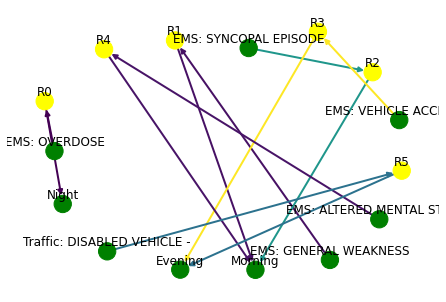

In [72]:
support = rules['support'].values
confidence = rules['confidence'].values

import seaborn as sns1

plt.title('Association Rules')
plt.xlabel('support')
plt.ylabel('confidence')
sns1.regplot(x=support,y=confidence,fit_reg=False)

plt.gcf().clear()
draw_graph(rules,6)

FP Growth


In [74]:
import itertools as it
from itertools import *

# help function
def partition(pred, iterable):
    t1, t2 = it.tee(iterable)
    return it.filterfalse(pred, t1), filter(pred, t2)

# divides list on all possible pairs
def part2(el_list):
    pairs = [[[x[1] for x in f] for f in partition(lambda x: x[0], zip(pattern, el_list))] \
     for pattern in product([True, False], repeat=len(el_list))]
    # remove pairs as [] -> [some content], [some content] -> []
    return pairs[1:-1]

In [75]:
from mlxtend.frequent_patterns import fpgrowth
import time

start_time=time.time()
f_patterns = fpgrowth(df_new, min_support=0.005, use_colnames=True)
f_patterns
end_time=time.time()

# convert dataframe to dictionary
supports = f_patterns['support'].to_list()
itemsets = f_patterns['itemsets'].to_list()

patterns_dict = {}
for x in range(len(itemsets)):
    patterns_dict[tuple(sorted(itemsets[x]))] = supports[x]

# generate asssociation_rules
as_rules_dict = {'antecedents': [], 'consequents': [], 'confidence': [], 'support': []}
for pattern, support in patterns_dict.items():
    if len(pattern) > 1:
        upper_support = support
        as_rules = part2(pattern)
        
        for as_r in as_rules:
            left_part = sorted(as_r[0])
            right_part = as_r[1]
            lower_support = patterns_dict[tuple(left_part)]
            conf = upper_support / lower_support
            
            as_rules_dict['antecedents'].append(left_part)
            as_rules_dict['consequents'].append(right_part)
            as_rules_dict['confidence'].append(conf)
            as_rules_dict['support'].append(upper_support)
            
print("time elapsed", (end_time-start_time)/60)

strong_as_rules = pd.DataFrame.from_dict(as_rules_dict)
# sort by confidence, remove all rules with confidence lower than 0.8
strong_as_rules = strong_as_rules.sort_values('confidence', ascending=False)
strong_as_rules = strong_as_rules[strong_as_rules['confidence'] > 0.1]


time elapsed 0.10766432285308838


In [76]:
final_as_rules=strong_as_rules
for i in strong_as_rules.index:
    count=0
    count1=0
    for a in strong_as_rules['antecedents'][i]:
        if a in days+months+times:
            count=count+1
        if a in townships+days+months+times and strong_as_rules['consequents'][i][0] in townships+days+months+times:
            count1=count1+1
    if count==len(strong_as_rules['antecedents'][i]) or count==len(strong_as_rules['antecedents'][i]):
        final_as_rules.drop(i,inplace=True)

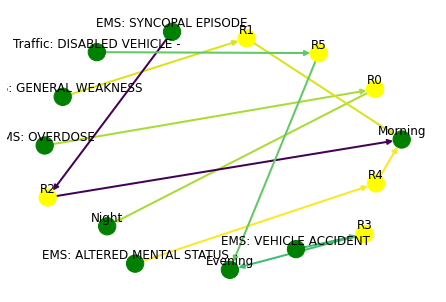

In [77]:
support = final_as_rules['support'].values
confidence = final_as_rules['confidence'].values

for i in range (len(support)):
    support[i] = support[i]
    confidence[i] = confidence[i]

plt.title('Association Rules')
plt.xlabel('support')
plt.ylabel('confidence')
sns.regplot(x=support,y=confidence,fit_reg=False)

plt.gcf().clear()
draw_graph(final_as_rules,6)

### **Rule Cleaning**

Traffic Accidents


In [78]:
list_col=[]
for col in df_new.columns:
  if(str(col)[:3] not in ['EMS', 'Fir', 'Oth', 'Tra']):
    list_col.append(str(col))
  if(str(col) in ['Traffic: VEHICLE ACCIDENT -']):
    list_col.append(str(col))

In [79]:
df_Traffic=df_new.filter(list_col)

In [80]:
frq_items = apriori(df_Traffic, min_support = 0.005, use_colnames = True,low_memory=True) 
rules_Traffic = association_rules(frq_items, metric ="lift", min_threshold = 0.03) 
rules_Traffic = rules_Traffic.sort_values(['confidence', 'lift'], ascending =[False, False]) 
print(rules_Traffic.head()) 

      antecedents consequents  ...  leverage  conviction
295  (WHITEMARSH)   (Morning)  ...  0.000574    1.031253
596         (Mon)   (Morning)  ...  0.003173    1.031182
623  (March, Fri)   (Evening)  ...  0.000421    1.036120
77      (HORSHAM)   (Morning)  ...  0.000595    1.028955
236  (TOWAMENCIN)   (Morning)  ...  0.000314    1.025568

[5 rows x 9 columns]


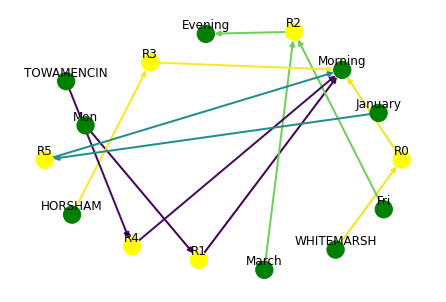

In [81]:
support = rules_Traffic['support'].values
confidence = rules_Traffic['confidence'].values

import seaborn as sns1

plt.title('Association Rules')
plt.xlabel('support')
plt.ylabel('confidence')
sns1.regplot(x=support,y=confidence,fit_reg=False)

plt.gcf().clear()
draw_graph(rules_Traffic,6)

EMS

In [82]:
list_col=[]
for col in df_new.columns:
  if(str(col)[:3] not in ['EMS', 'Fir', 'Oth', 'Tra']):
    list_col.append(str(col))
  if(str(col) in ['EMS: OVERDOSE']):
    list_col.append(str(col))

In [83]:
df_EMS=df_new.filter(list_col)

In [84]:
df_EMS.head()

EMS: OVERDOSE  ABINGTON  AMBLER  BERKS COUNTY  ...  Sun  Thu  Tue  Wed
0              0         0       0             0  ...    0    1    0    0
1              0         0       0             0  ...    0    1    0    0
2              0         0       0             0  ...    0    1    0    0
3              0         0       0             0  ...    0    1    0    0
5              0         0       0             0  ...    0    1    0    0

[5 rows x 92 columns]

In [85]:
frq_items = apriori(df_EMS, min_support = 0.005, use_colnames = True,low_memory=True) 
rules_EMS = association_rules(frq_items, metric ="lift", min_threshold = 0.03) 
rules_EMS = rules_EMS.sort_values(['confidence', 'lift'], ascending =[False, False]) 
print(rules_EMS.head()) 

         antecedents consequents  ...  leverage  conviction
1    (EMS: OVERDOSE)     (Night)  ...  0.002606    1.320548
297     (WHITEMARSH)   (Morning)  ...  0.000574    1.031253
598            (Mon)   (Morning)  ...  0.003173    1.031182
625     (March, Fri)   (Evening)  ...  0.000421    1.036120
79         (HORSHAM)   (Morning)  ...  0.000595    1.028955

[5 rows x 9 columns]


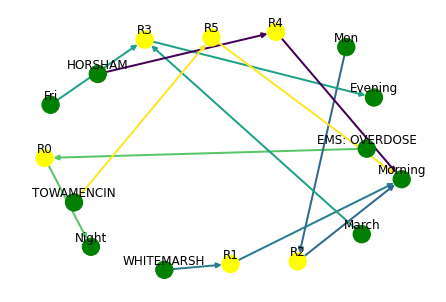

In [86]:
support = rules_EMS['support'].values
confidence = rules_EMS['confidence'].values

import seaborn as sns1

plt.title('Association Rules')
plt.xlabel('support')
plt.ylabel('confidence')
sns1.regplot(x=support,y=confidence,fit_reg=False)

plt.gcf().clear()
draw_graph(rules_EMS,6)